# Convert Chain to Function Automatically.

## Preliminaries

### Imports

In [1]:
import os
import pandas as pd
import sys
import networkx as nx

from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus
from morpheus.composition import compose
from morpheus.tests import default_chain, default_ensemble, default_dataset
from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format,
                           add_merge_nodes)

In [2]:
from functools import partial

In [3]:
# In Greek to avoid nameclashes
ω = compose.o
χ = compose.x

### Functions

In [4]:
def fix_layout(G):
    
    for n in G.nodes():
        node = G.nodes(data=True)[n]
        if node['bipartite'] == 'func':
            node['shape'] = "\"square\""
            node['width'] = "2"
        elif node['bipartite'] == 'data':
            node['shape'] = "\"circle\""
        else:
            pass
    
    return G

### Ensemble

In [5]:
data, _ = default_dataset(random_state=16)
c = default_chain(random_state=16)


        Learning model with desc ids:    [0, 1, 2]
                            targ ids:    [4, 5]
        

        Learning model with desc ids:    [1, 2, 5]
                            targ ids:    [7]
        

            Trying to add a model to end of the chain.
            
            Current chain targ_ids:     [4. 5.]
            New estimator desc_ids:     [1, 2, 5]
            


            Connecting attributes:  [5.]
            



In [6]:
data.values.shape

(800, 8)

In [7]:
c.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2.]
        Target attributes:          [4. 7.]

        ## On types (mostly nominals)
        Target attribute types:                     ['numeric', 'nominal']
        N_classes of nominal target attributes:     [2]
        Classes of nominal target attributes:       [array([0., 1.])]

        ## Weights
        Total weights of target attributes:         [1. 1.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestClassifier']
        N_estimators:           2
        


## Conversion

In [8]:
model_one = c.estimators_[0]
model_two = c.estimators_[1]

In [9]:
G_one = model_to_graph(model_one, idx=1)
G_two = model_to_graph(model_two, idx=2)

In [10]:
G = nx.compose(G_one, G_two)

In [11]:
G = fix_layout(G)

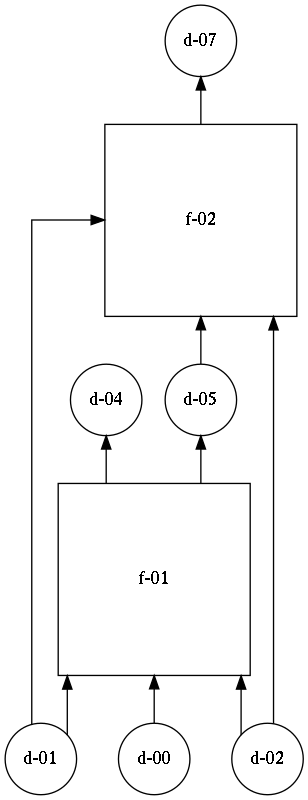

In [12]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [13]:
add_merge_nodes(G)

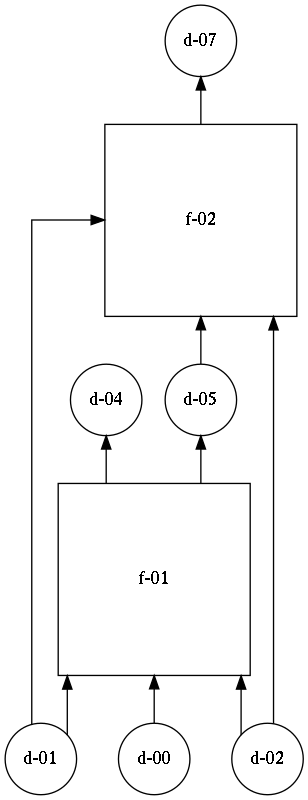

In [14]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [15]:
import numpy as np

def select(idx):
    
    def select(X):
        if len(X.shape) > 1:
            return X[:, idx]
        elif len(X.shape) == 1:
            assert idx == 0
            return X
    return select

In [16]:
def convert_graph_to_functions(G):
    # Convert the graph to its functions
    sorted_list = list(nx.topological_sort(G))
    print(sorted_list)
    functions = {}
    for node_name in sorted_list:
        node = G.nodes(data=True)[node_name]
        print(node_name)
        if node.get('kind', None) == 'data': 
            if len(nx.ancestors(G, node_name)) == 0:
                functions[node_name] = select(node['idx'])
            else:

                # This is pretty much identical to what happens in the merge node
                previous_node = [t[0] for t in G.in_edges(node_name)][0] # I know it is just one
                previous_t_idx = G.nodes()[previous_node]['tgt'] 

                relevant_idx = previous_t_idx.index(node['idx'])

                functions[node_name] = ω(select(relevant_idx), functions[previous_node])


        elif node.get('kind', None) == 'model':

            previous_nodes = [t[0] for t in G.in_edges(node_name)]

            print(functions.keys())
            inputs = [functions[n] for n in previous_nodes]
            inputs = ω(np.transpose, χ(*inputs, return_type=np.array))
            f = node['function']
            functions[node_name] = ω(f, inputs)

        elif node.get('kind', None) == 'merge':
            merge_idx = node['idx']
            previous_nodes = [t[0] for t in G.in_edges(node_name)]
            previous_t_idx = [G.nodes()[n]['tgt'] for n in previous_nodes]
            print(previous_t_idx)
            inputs = [(functions[n],t) for n, t in zip(previous_nodes, previous_t_idx)]

            inputs = [ω(select(t_idx.index(merge_idx)), f) for f, t_idx in inputs]
            inputs = ω(np.transpose, χ(*inputs, return_type=np.array))

            f = partial(np.mean, axis=1)
            functions[node_name] = ω(f, inputs)
    return functions

In [17]:
functions =  convert_graph_to_functions(G)
functions

['d-02', 'd-01', 'd-00', 'f-01', 'd-05', 'f-02', 'd-07', 'd-04']
d-02
d-01
d-00
f-01
dict_keys(['d-02', 'd-01', 'd-00'])
d-05
f-02
dict_keys(['d-02', 'd-01', 'd-00', 'f-01', 'd-05'])
d-07
d-04


{'d-02': <function __main__.select.<locals>.select(X)>,
 'd-01': <function __main__.select.<locals>.select(X)>,
 'd-00': <function __main__.select.<locals>.select(X)>,
 'f-01': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-05': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'f-02': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-07': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-04': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>}

In [18]:
a = functions['d-07'](data.values)
b = functions['f-02'](data.values)

In [19]:
a-b # all zeroes, lgtm

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Crazy chain

In [20]:
G_three = model_to_graph(model_two, idx=3)

In [21]:
G_adv = nx.compose(G, G_three)
G_adv = fix_layout(G_adv)
add_merge_nodes(G_adv)

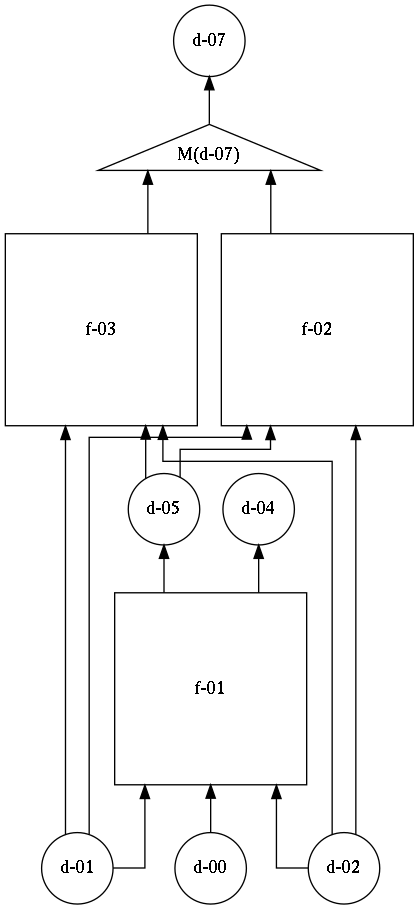

In [22]:
X = to_pydot(G_adv)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [23]:
f_adv = convert_graph_to_functions(G_adv)
f_adv

['d-02', 'd-01', 'd-00', 'f-01', 'd-05', 'f-03', 'f-02', 'M(d-07)', 'd-07', 'd-04']
d-02
d-01
d-00
f-01
dict_keys(['d-02', 'd-01', 'd-00'])
d-05
f-03
dict_keys(['d-02', 'd-01', 'd-00', 'f-01', 'd-05'])
f-02
dict_keys(['d-02', 'd-01', 'd-00', 'f-01', 'd-05', 'f-03'])
M(d-07)
[[7], [7]]
d-07
d-04


{'d-02': <function __main__.select.<locals>.select(X)>,
 'd-01': <function __main__.select.<locals>.select(X)>,
 'd-00': <function __main__.select.<locals>.select(X)>,
 'f-01': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-05': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'f-03': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'f-02': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'M(d-07)': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-07': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-04': <function morpheus.composition.compose.o.<locals>.sequential_composition(*function_arguments)>}

In [28]:
f_adv['d-04'](data.values)[:10]

array([-1.50945153, -0.94141726, -1.07336243, -1.50945153, -1.42220159,
       -2.55355904, -1.48396813, -1.2143633 , -1.87749991, -1.3467215 ])

In [26]:
data.head()

,0,1,2,3,4,5,6,y
0,-0.499073,0.355756,-2.067821,1.190195,-1.500605,2.365067,1.144163,0
1,1.925204,-1.323785,-0.079357,2.555430,-0.889406,-0.995612,1.765216,1
2,-1.666397,-0.589412,-0.781130,2.252310,1.075427,0.411382,-0.259435,1
3,-0.146030,0.014408,-1.753408,1.292067,-0.961351,-2.085965,1.843809,0
4,1.195750,-1.378685,-2.366139,0.293899,0.158766,2.957540,-0.098090,1


In [31]:
f_adv['d-07'](data.values) - data.values[:, 7]

array([ 0., -1., -1.,  0., -1.,  0.,  1., -1., -1.,  0.,  0.,  1.,  1.,
       -1.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,  1.,  0.,  1.,  0.,
       -1.,  1.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0., -1.,
       -1.,  0.,  0.,  0.,  0., -1., -1.,  0., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  1.,  0., -1., -1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  1., -1.,
        0.,  0., -1.,  0., -1.,  1.,  0.,  0.,  0., -1.,  0., -1., -1.,
        0.,  0.,  1., -1., -1.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,
        1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  1., -1., -1., -1.,  0., -1., -1.,  0.,  0.,
        1., -1.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  1.,
        0.,  0.,  0., -1.,  1., -1.,  1., -1., -1.,  0.,  0.,  1.,  0.,
       -1.,  1., -1.,  0.,  0., -1.,  0., -1., -1., -1., -1.,  0